In [1]:
import pandas as pd
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate, Bidirectional, GRU 
from keras import Model
from keras import optimizers
from tensorflow import keras

In [2]:
data_full = pd.read_csv('Intrahour Volatility Dataset.csv')

In [3]:
X = data_full[["Return_Squared", "Hourly Volatility"]]
Y = data_full["target"]
data_set = data_full[["Date","Return_Squared", "Hourly Volatility", "target"]]

In [4]:
#Train-test split
splitlimit = int(len(data_full)*0.8)
training_features, test_data = data_set[:splitlimit], data_set[splitlimit:]

In [5]:
#Outlier Detection in training_data_features

training_features["hourly_volatility_rolling_median"] = training_features["Hourly Volatility"].rolling(window=41, center=True, min_periods=1).median()
training_features["return_squared_rolling_median"] = training_features["Return_Squared"].rolling(window=41, center=True, min_periods=1).median()
training_features["volatility minus median"] = (training_features["Hourly Volatility"] - training_features["hourly_volatility_rolling_median"]).abs()
training_features["return minus median"] = (training_features["Return_Squared"] - training_features["return_squared_rolling_median"]).abs()
volatility_outliers_removed = training_features[~(training_features['volatility minus median'] > 5 * training_features['volatility minus median'].median())]
both_outliers_removed = volatility_outliers_removed[~(volatility_outliers_removed['return minus median'] > 5 * volatility_outliers_removed['return minus median'].median())]

/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_18498/1338683924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features["hourly_volatility_rolling_median"] = training_features["Hourly Volatility"].rolling(window=41, center=True, min_periods=1).median()
/var/folders/cb/9kkmszhd7fx9_93t2qb1_s640000gn/T/ipykernel_18498/1338683924.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_features["return_squared_rolling_median"] = training_features["Return_Squared"].rolling(window=4

In [6]:
X_cleaned = both_outliers_removed[["Return_Squared", "Hourly Volatility"]]
Y_cleaned = both_outliers_removed["target"]
data_set_cleaned = both_outliers_removed[["Return_Squared", "Hourly Volatility", "target"]]

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
training_data_features_scaled = scaler.fit_transform(X_cleaned)
data_set_scaled = scaler.fit_transform(data_set_cleaned)

In [8]:
#Reconstructing training data 

Z = []

backcandles = 15

for j in range(2):
    Z.append([])
    for i in range(backcandles, training_data_features_scaled.shape[0]):
        Z[j].append(training_data_features_scaled[i-backcandles:i, j])
        
Z = np.moveaxis(Z, [0], [2])
Z, yi = np.array(Z), np.array(data_set_scaled[backcandles-1:, -1])
y_final = np.reshape(yi,(len(yi),1))
y_final = y_final[1:]

In [9]:
#OGRU Cell and Layer
import tensorflow as tf
from tensorflow.keras.layers import Layer

           
class OGRUCell(Layer):
    def __init__(self, units, **kwargs):
        super(OGRUCell, self).__init__(**kwargs)
        self.units = units
        self.state_size = units  
        self.output_size = units  
        
    def build(self, input_shape):
        self.Wr = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='Wr')
        self.Ur = self.add_weight(shape=(self.units, self.units),
                                  initializer='orthogonal',
                                  name='Ur')
        self.Wz = self.add_weight(shape=(input_shape[-1], self.units),
                                  initializer='glorot_uniform',
                                  name='Wz')
        self.Uz = self.add_weight(shape=(self.units, self.units),
                                  initializer='orthogonal',
                                  name='Uz')
        self.W = self.add_weight(shape=(input_shape[-1], self.units),
                                 initializer='glorot_uniform',
                                 name='W')
        self.U = self.add_weight(shape=(self.units, self.units),
                                 initializer='orthogonal',
                                 name='U')
        self.bias_r = self.add_weight(shape=(self.units,),
                                      initializer='zeros',
                                      name='bias_r')
        self.bias_z = self.add_weight(shape=(self.units,),
                                      initializer='zeros',
                                      name='bias_z')
        self.bias_h = self.add_weight(shape=(self.units,),
                                      initializer='zeros',
                                      name='bias_h')

    
    def call(self, inputs, states):
        prev_h = states[0]

        r = tf.sigmoid(tf.matmul(inputs, self.Wr) + tf.matmul(prev_h, self.Ur) + self.bias_r)
        
        r_reduced = tf.reduce_mean(r, axis=-1, keepdims=True)  # Averaging across the units dimension
        r_reduced = tf.tile(r_reduced, [1, inputs.shape[-1]])

      
        z = tf.sigmoid(tf.matmul(inputs * r_reduced, self.Wz) + tf.matmul(prev_h, self.Uz) + self.bias_z)

        n = tf.tanh(tf.matmul(inputs, self.W) + tf.matmul(prev_h * r, self.U) + self.bias_h)

        h = (1 - z) * prev_h + z * n

        return h, [h]


# Producing OGRU layer 
class OGRU(tf.keras.layers.RNN):
    def __init__(self, units, **kwargs):
        self.cell = OGRUCell(units, **kwargs)
        super(OGRU, self).__init__(self.cell, **kwargs)

# OGRU layer with 80 units
ogru_layer = OGRU(units=80)

In [18]:
#GRU model
gru_input = Input(shape = (backcandles, 2), name = 'gru_input')

inputs = GRU(80, name='first_layer')(gru_input)

inputs = Dense(1, name='dense_layer')(inputs)

output = Activation('sigmoid', name = 'output')(inputs)

model = Model(inputs = gru_input, outputs = output)

model.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

history = model.fit(x=Z, y=y_final, epochs = 50, validation_data = (Z, y_final))

Epoch 1/50
1349/1349 [==============================] - 5s 3ms/step - loss: 0.6353 - accuracy: 0.6330 - val_loss: 0.6194 - val_accuracy: 0.6489
Epoch 2/50
1349/1349 [==============================] - 5s 3ms/step - loss: 0.6093 - accuracy: 0.6639 - val_loss: 0.6040 - val_accuracy: 0.6704
Epoch 3/50
1349/1349 [==============================] - 4s 3ms/step - loss: 0.6030 - accuracy: 0.6700 - val_loss: 0.5994 - val_accuracy: 0.6761
Epoch 4/50
1349/1349 [==============================] - 4s 3ms/step - loss: 0.6007 - accuracy: 0.6740 - val_loss: 0.5990 - val_accuracy: 0.6733
Epoch 5/50
1349/1349 [==============================] - 4s 3ms/step - loss: 0.5982 - accuracy: 0.6745 - val_loss: 0.6003 - val_accuracy: 0.6709
Epoch 6/50
1349/1349 [==============================] - 4s 3ms/step - loss: 0.5975 - accuracy: 0.6771 - val_loss: 0.5971 - val_accuracy: 0.6764
Epoch 7/50
1349/1349 [==============================] - 4s 3ms/step - loss: 0.5965 - accuracy: 0.6755 - val_loss: 0.5948 - val_accuracy:

In [19]:
#OGRU model
ogru_input = Input(shape = (backcandles, 2), name = 'ogru_input')

inputs = ogru_layer(ogru_input)

inputs = Dense(1, name='dense_layer')(inputs)

output = Activation('sigmoid', name = 'output')(inputs)

model2 = Model(inputs = ogru_input, outputs = output)

model2.compile(optimizer="adam", loss = "binary_crossentropy", metrics = ["accuracy"])

history2 = model2.fit(x=Z, y=y_final, epochs = 50, validation_data = (Z, y_final))

Epoch 1/50
1349/1349 [==============================] - 6s 4ms/step - loss: 0.5965 - accuracy: 0.6738 - val_loss: 0.5701 - val_accuracy: 0.6980
Epoch 2/50
1349/1349 [==============================] - 6s 4ms/step - loss: 0.5697 - accuracy: 0.6964 - val_loss: 0.5613 - val_accuracy: 0.7067
Epoch 3/50
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5642 - accuracy: 0.7042 - val_loss: 0.5570 - val_accuracy: 0.7109
Epoch 4/50
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5611 - accuracy: 0.7049 - val_loss: 0.5545 - val_accuracy: 0.7121
Epoch 5/50
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5569 - accuracy: 0.7100 - val_loss: 0.5480 - val_accuracy: 0.7169
Epoch 6/50
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5528 - accuracy: 0.7110 - val_loss: 0.5430 - val_accuracy: 0.7200
Epoch 7/50
1349/1349 [==============================] - 5s 4ms/step - loss: 0.5487 - accuracy: 0.7167 - val_loss: 0.5397 - val_accuracy:

In [ ]:
#gru plot
history.history.keys() 
plt.plot(history.history['loss'], color = 'red', label = "Training Loss")
plt.plot(history.history['accuracy'], color = 'royalblue', label = "Training Accuracy")
plt.xlabel('Number of Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)
plt.legend(fontsize= 12)
#plt.savefig('GRU.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#ogru plot
history2.history.keys() 
plt.plot(history3.history['loss'], color = 'red', label = "Training Loss")
plt.plot(history3.history['accuracy'], color = 'royalblue', label = "Training Accuracy")
plt.xlabel('Number of Epochs', fontsize = 15)
plt.ylabel('Accuracy', fontsize = 15)
plt.gca().tick_params(axis='x', labelsize=12)
plt.gca().tick_params(axis='y', labelsize=12)
plt.legend(fontsize= 12)
#plt.savefig('MyGRU.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


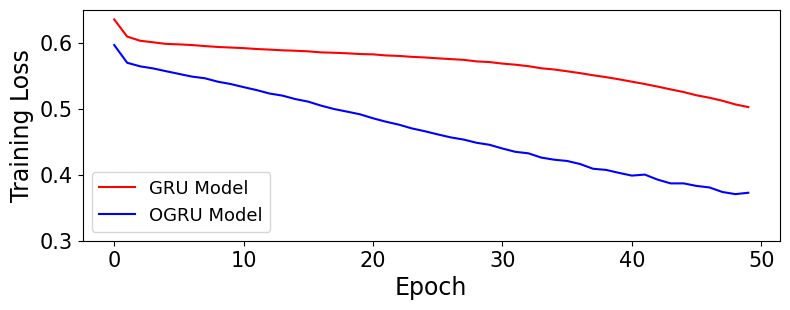

In [23]:
#Figure 6.3
plt.figure(figsize=(9, 3))
plt.plot(history.history['loss'], color = 'red', label='GRU Model')
plt.plot(history2.history['loss'], color = 'blue', label='OGRU Model')
plt.gca().tick_params(axis='x', labelsize=15)
plt.gca().tick_params(axis='y', labelsize=15) 
plt.xlabel('Epoch', size = 17)
plt.ylim(0.30, 0.65)
plt.ylabel('Training Loss', size = 17)
plt.legend(fontsize = 13)
plt.savefig('GRU vs OGRU.jpg', format='jpg', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
#This additional section provides the out-of-sample results of the GRU vs OGRU

In [24]:
X_test = test_data[["Return_Squared", "Hourly Volatility"]]
Y_test = test_data["target"]
test_dataset = test_data[["Return_Squared", "Hourly Volatility", "target"]]

In [25]:
test_scaled = scaler.fit_transform(test_dataset)
X_test_scaled = scaler.fit_transform(X_test)

In [32]:
T = []

backcandles = 15

for j in range(2):
    T.append([])
    for i in range(backcandles, X_test_scaled.shape[0]):
        T[j].append(X_test_scaled[i-backcandles:i, j])

In [33]:
T = np.moveaxis(T, [0], [2])
T, yi_test = np.array(T), np.array(test_scaled[backcandles-1:, -1])
y_final_test = np.reshape(yi_test,(len(yi_test),1))
y_final_test = y_final_test[1:]

In [43]:
#gru out-of-sample
test_predictions1 = model.predict(T)
test_predicted_classes1 = (test_predictions1 > 0.5).astype(int)
dataframe1 = pd.DataFrame(y_final_test, columns = ["target"])
dataframe1["predicted"] = test_predicted_classes1
cm_gru = confusion_matrix(dataframe1['predicted'], dataframe1['target'])
print(cm_gru)

[[4645 1286]
 [3422 5025]]


In [42]:
#ogru out-of-sample
test_predictions2 = model2.predict(T)
test_predicted_classes2 = (test_predictions2 > 0.5).astype(int)
dataframe2 = pd.DataFrame(y_final_test, columns = ["target"])
dataframe2["predicted"] = test_predicted_classes2
cm_ogru = confusion_matrix(dataframe2['predicted'], dataframe2['target'])
print(cm_ogru)

[[4490 1600]
 [3577 4711]]
